## Содержание

- [Шаг 1. Загрузка данных](#шаг1)
- [Шаг 2. Исследовательский анализ данных (EDA)](#шаг2)
    - [Проверка датасета на отсутствующие значения, изучение стандартной статистики](#шаг2.1)
    - [Сравнение средних значений признаков в группах ушедших и оставшихся пользователей](#шаг2.2)
    - [Матрица корреляции](#шаг2.4)
- [Шаг 3. Обучение модели прогнозирования оттока клиентов](#шаг3)
    - [Построю модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце](#шаг3.1)
    - [Изучу метрики классификации для выбора лучшей модели](#шаг3.4)
- [Шаг 4. Сделаю кластеризацию клиентов (обучение без учителя)](#шаг4)
    - [Метод linkage() для построения дендрограммы](#шаг4.3)
    - [Модель кластеризации на основании алгоритма K-Means](#шаг4.4)
        - [Сравнение средних по кластерам, выводы](#шаг4.5)
        - [Сравнение распределения признаков по кластерам, выводы](#шаг4.6)
        - [Сравнение кластеров по доле оттока](#шаг4.7)
- [Шаг 5. Выводы и рекомендации для бизнеса](#шаг5)

## Шаг 1.<a id='шаг1'></a> Загрузите данные

Заказчик - фитнес-центр - предоставил данные по оттоку посетителей и хочет понять, как улучшить показатели.

Общие данные по клиентам:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Текущий статус клиентов фитнес-центра:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [1]:
# Импорт функций
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# варианты загрузки для локальной работы и через тренажер
try:
    gym = pd.read_csv('datasets/gym_churn.csv')
except:
    gym = pd.read_csv('/datasets/gym_churn.csv')

gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
# проверка на дубликаты
gym.duplicated().sum()

0

**Вывод**: в предоставленных данных есть 4 тыс. наблюдений без пропусков. Для 13 исходных параметров и бинарного целевого признака более чем достаточно.

## Шаг 2<a id='шаг2'></a>. Исследовательский анализ данных (EDA)

##### <a id='шаг2.1'></a>Проверка датасета на отсутствующие значения, изучение стандартной статистики

In [5]:
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [6]:
cols_bool = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits', 'Churn']

In [7]:
cols_not_bool = [col for col in gym.columns if col not in cols_bool]
cols_not_bool.remove('Avg_additional_charges_total')
cols_not_bool.remove('Age')

Средние значения для колонок типа да/нет

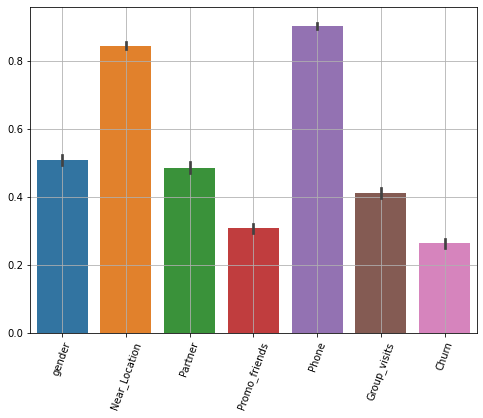

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=gym[cols_bool])
plt.xticks(rotation=70)
plt.grid()
plt.show()

Для остальных колонок

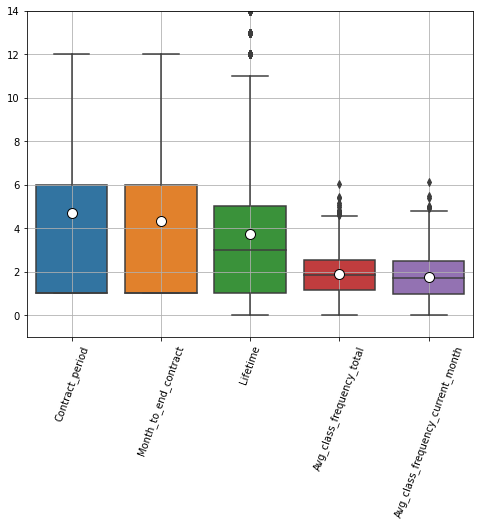

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=gym[cols_not_bool], showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.xticks(rotation=70)
ax.set_ylim(-1,14)
plt.grid()
plt.show()

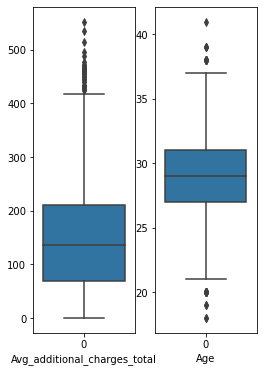

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 6))
for i, col in enumerate(['Avg_additional_charges_total', 'Age']):
    sns.boxplot(data=gym[col], ax=ax[i])
    ax[i].set_xlabel(col)
plt.show()

##### Портрет среднестатистического клиента:
- любой пол
- живёт поблизости
- указал телефон для связи
- 27-31 год
- Потратил 80-200 единиц (долларов?) на другие услуги.
- Срок абонемента 1-6 месяцев.
- До конца абонемента 1-6 месяцев.
- Посещает занятия уже 1-5 месяцев с частотой 1-3 раза в неделю.

Менее характерно:
- скорее без скидки от друзей

<a id='шаг2.2'></a>Сравнение средних значений признаков в группах ушедших и оставшихся пользователей

In [11]:
gym.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


##### По средним, предварительные выводы, остаются чаще те:
- кто имеет срок абонемента 3 месяца и более,
- кто ходит на групповые занятия,
- кто тратит больше денег дополнительно,
- у кого абонемент заканчивается не скоро,
- кто ходит давно (прошёл кризис желания уйти),
- кто ходит чаще и в текущем месяце и в целом

Немного охотнее остаются те, кто близко живёт, имеет абонемент компании партнёра или пришёл по приглашению друга.

##### <a id='шаг2.3'></a>Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

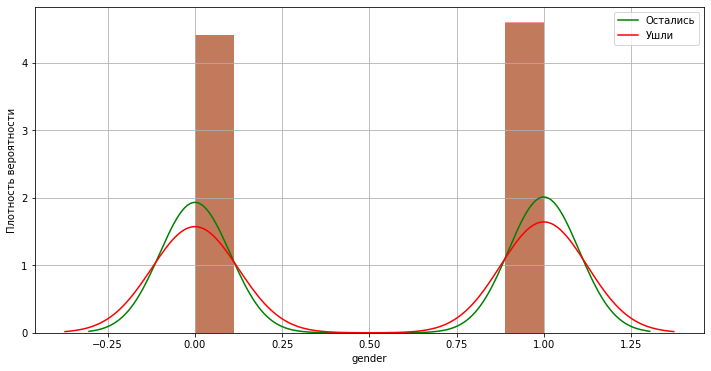

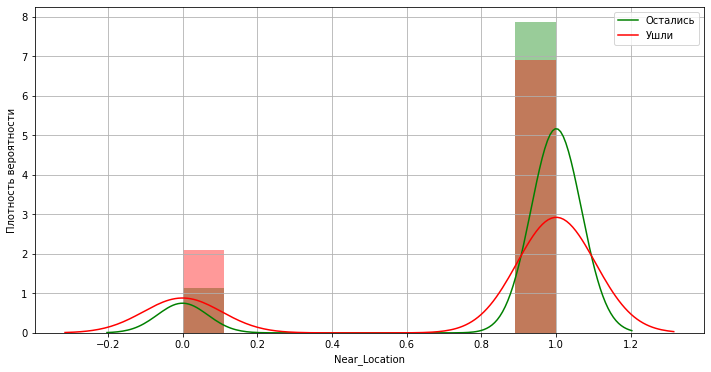

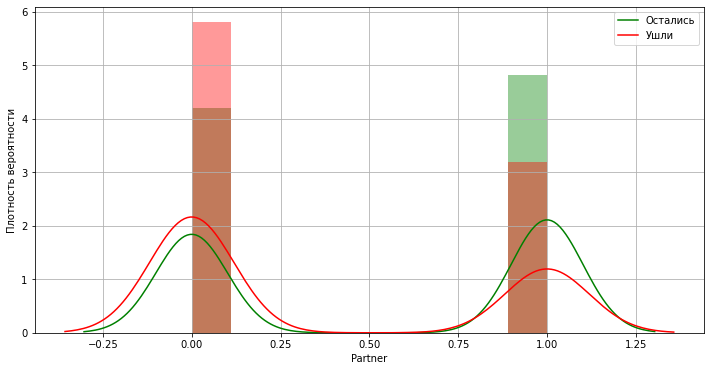

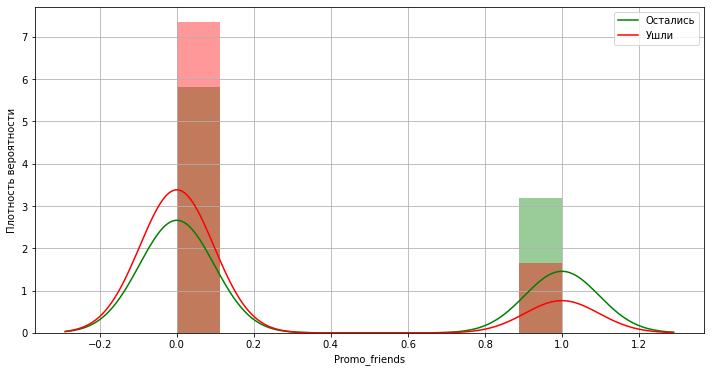

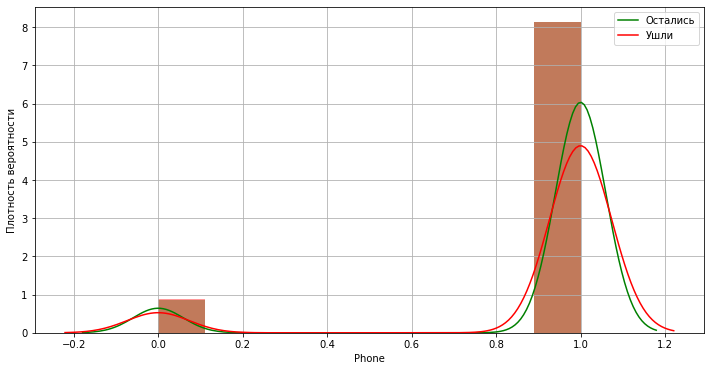

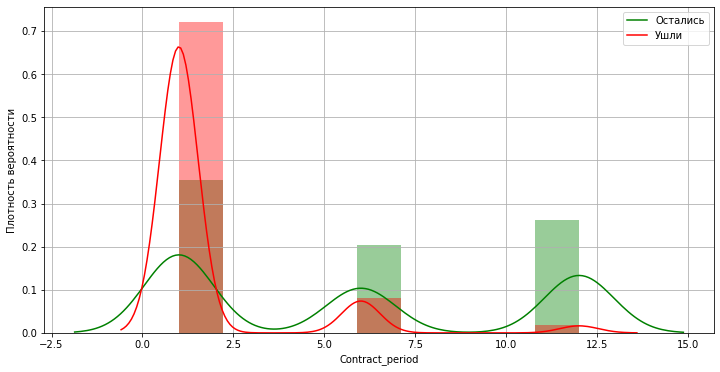

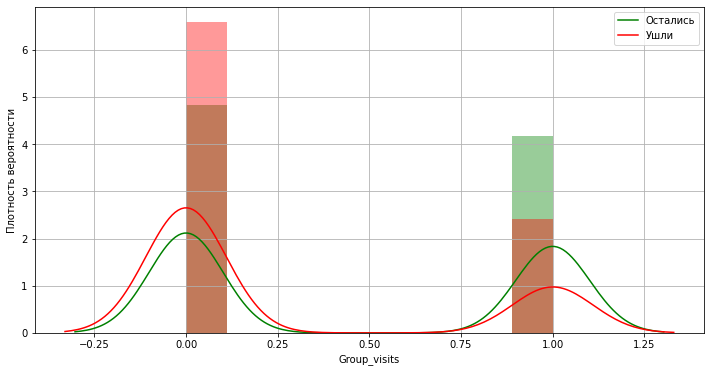

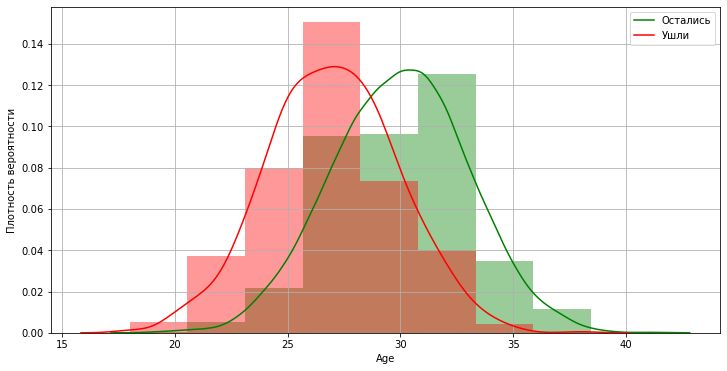

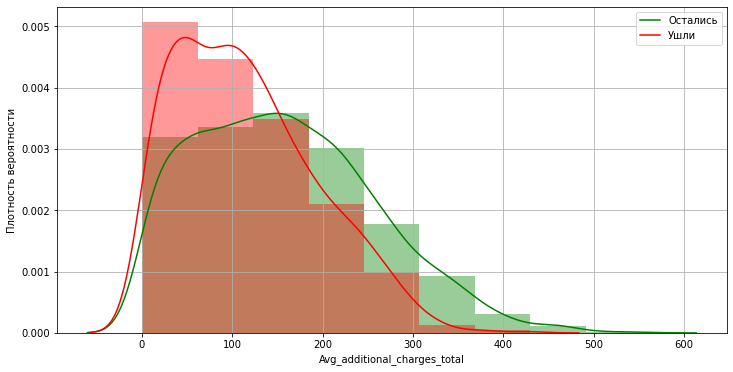

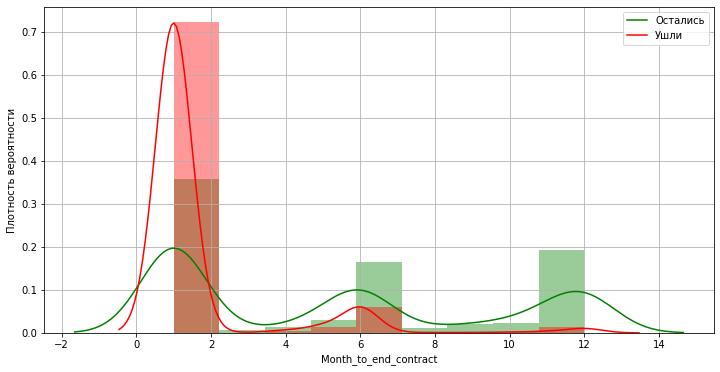

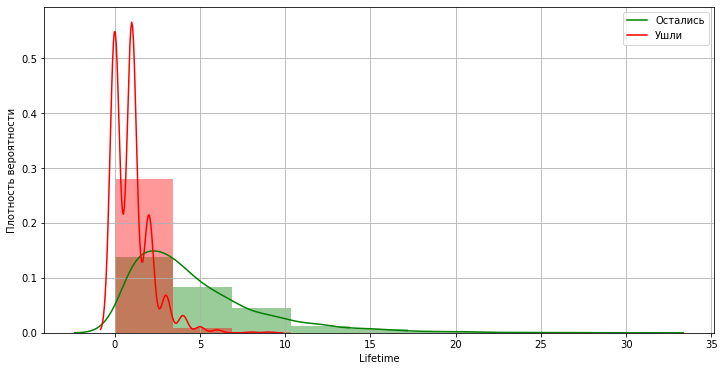

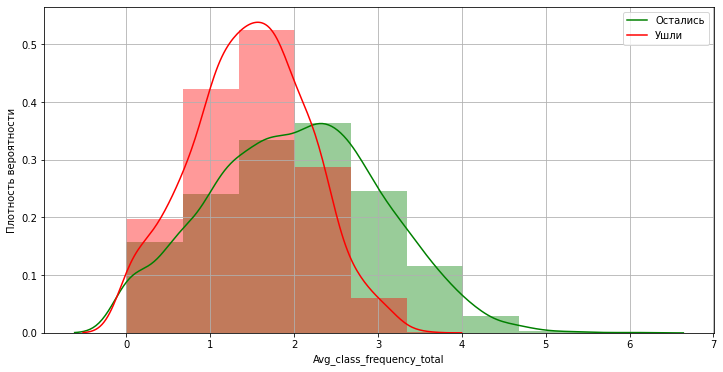

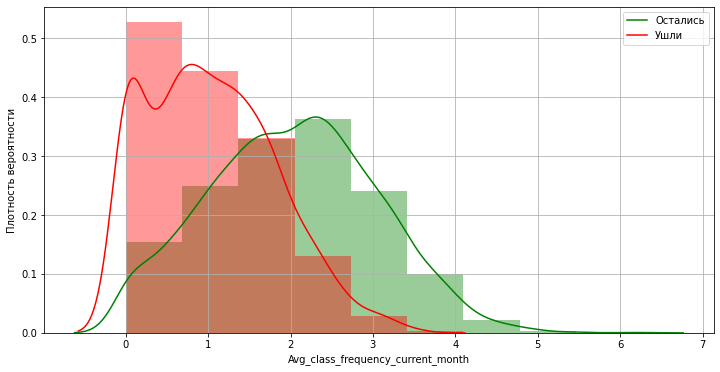

In [12]:
for col in gym.drop('Churn', axis=1).columns:
    min_ = gym[col].min()
    max_ = gym[col].max()
    bins = [min_+ 1/9*j*(max_ - min_) for j in range(10)]
    fig, ax = plt.subplots(figsize=(12,6))
    sns.distplot(gym[gym.Churn == 0][col], bins=bins, norm_hist=True, color='g')
    sns.distplot(gym[gym.Churn == 1][col], bins=bins, norm_hist=True, color='r')
    plt.ylabel('Плотность вероятности')
    plt.legend(['Остались','Ушли'])
    plt.grid()
    plt.show()

**Вывод**
Чаще уходят те:
- кому далеко добираться
- без скидки от партнера
- без скидки от друзей
- не ходящие на групповые занятия
- молодые (25-30 лет)
- те, кто не тратит деньги дополнительно
- те, кто пришёл недавно
- реже ходящие на занятия

Намного чаще:
- заключившие договор на короткий период
- у кого мало времени осталось до окончания договора

<a id='шаг2.4'></a>Матрица корреляции:

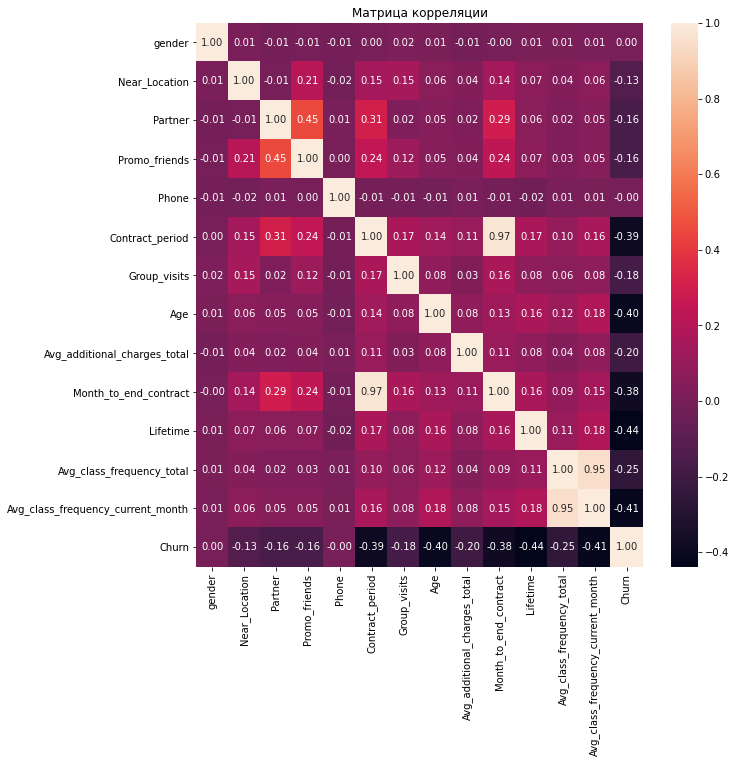

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
cm = gym.corr()
sns.heatmap(cm, annot=True, ax=ax, fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

**Вывод**: нет сильной связи признаков с целевой переменной, так что есть смысл применять машинное обучение.

Видна высокая корреляция между сроком в месяцах абонемента и оставшегося времени (0.97) и такая же высокая корреляция для частоты посещений зала в целом и в последний месяц.

## Шаг 3. <a id='шаг3'></a>Модель прогнозирования оттока клиентов

<a id='шаг3.2'></a>Разобью данные на обучающую и валидационную выборку функцией `train_test_split()`.

In [14]:
X = gym.drop('Churn', axis=1)
y = gym['Churn']

<a id='шаг4.2'></a>Подготовка - стандартизация.

In [15]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
X_st = pd.DataFrame(data=X_st, columns=X.columns)
X_st.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0.979706,0.427881,1.026861,1.497161,-3.059852,0.289890,1.194032,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472
1,-1.020715,0.427881,-0.973842,-0.667931,0.326813,1.608822,1.194032,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014
2,-1.020715,0.427881,1.026861,-0.667931,0.326813,-0.809219,-0.837498,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019
3,-1.020715,0.427881,1.026861,1.497161,0.326813,1.608822,1.194032,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450
4,0.979706,0.427881,1.026861,1.497161,0.326813,-0.809219,-0.837498,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542


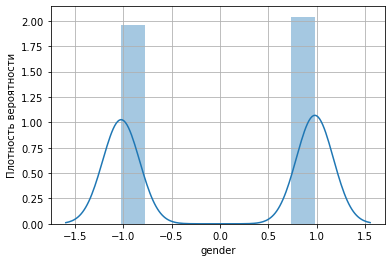

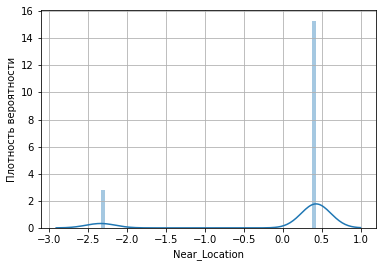

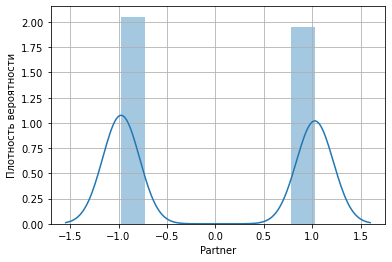

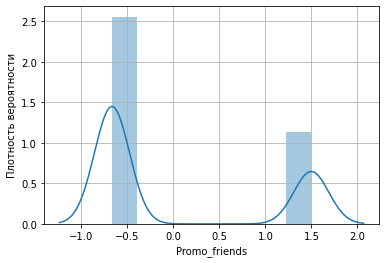

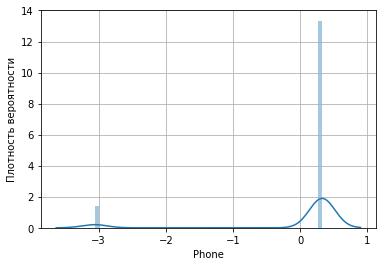

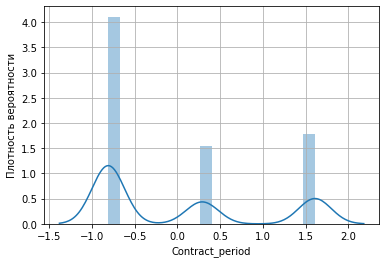

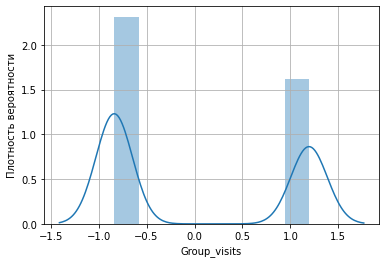

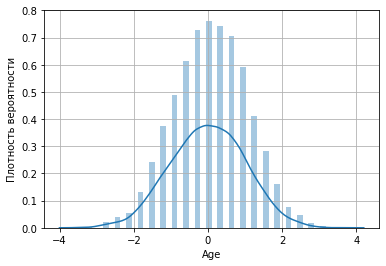

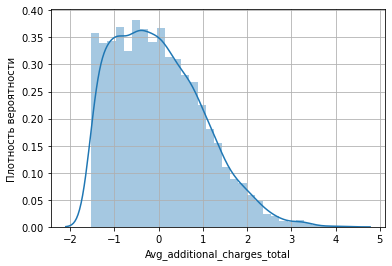

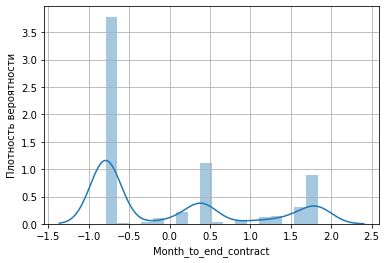

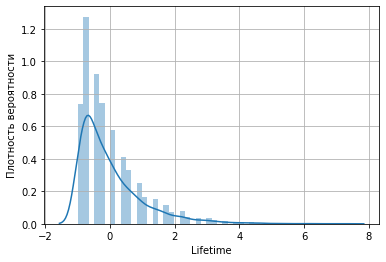

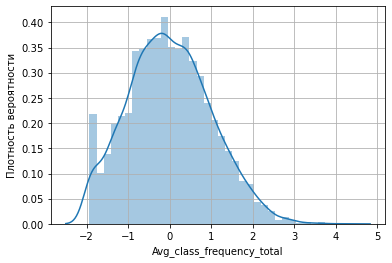

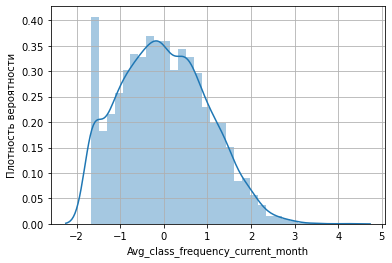

In [16]:
# проверка распределения
for col in X_st.columns:
    sns.distplot(X_st[col])
    plt.ylabel('Плотность вероятности')
    plt.grid()
    plt.show()

### <a id='шаг3.1'></a>Построю модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

Разбиение признаков на тренировочную и тестовую выборки:

In [17]:
X_train_st, X_test_st, y_train, y_test = train_test_split(X_st, y, test_size=0.2, random_state=0, stratify=y)

#### <a id='шаг3.3'></a>Обучу модель на train-выборке двумя способами:

Логистическая регрессия:

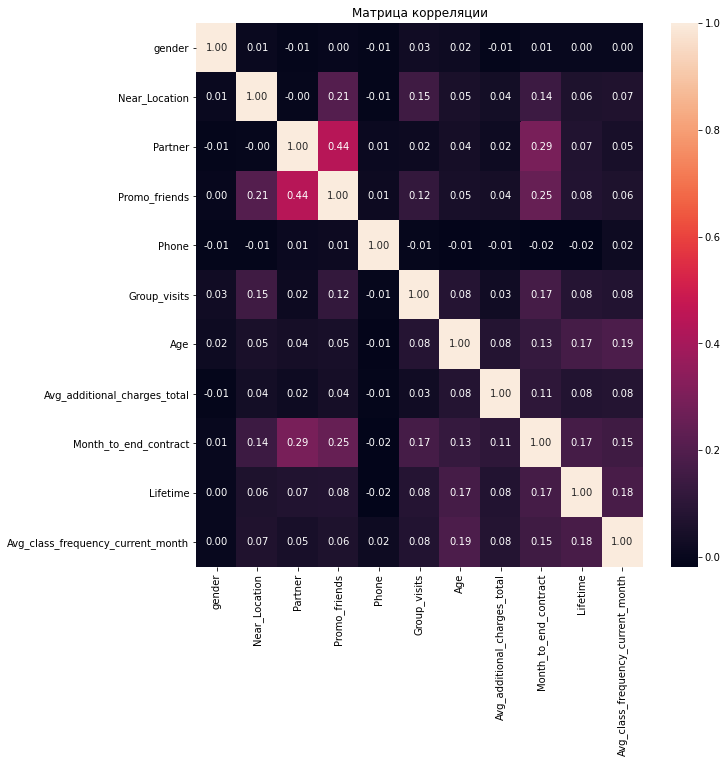

In [18]:
# убираю скоррелированные столбцы
X_train_st_log = X_train_st.drop(['Contract_period', 'Avg_class_frequency_total'], axis=1)
X_test_st_log = X_test_st.drop(['Contract_period', 'Avg_class_frequency_total'], axis=1)

# проверка
fig, ax = plt.subplots(figsize=(10,10))
cm = X_train_st_log.corr()
sns.heatmap(cm, annot=True, ax=ax, fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

In [19]:
model_log = LogisticRegression()
model_log.fit(X_train_st_log, y_train)
y_pred_log = model_log.predict(X_test_st_log)

Классификатор случайного леса:

In [20]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(X_train_st, y_train)
y_pred_tree = model_forest.predict(X_test_st)

### <a id='шаг3.4'></a>Изучу метрики классификации для выбора лучшей модели

Оценю соотношение классов:

In [21]:
gym.Churn.mean()

0.26525

Уходит приблизительно четверть клиентов, 3/4 остаются. Метрика `accuracy` в данном случае будет менее точна, лучше показывают качество алгоритма `precision` и `recall`.
- `precision` - "точность" - показывает, какой процент из предсказанных клиентов реально уходит.
- `recall` - "полнота" - какой процент от уходящих клиентов удалось определить с помощью модели.

Логистическая регрессия:

In [22]:
print('Accuracy: {:.1%}'.format(accuracy_score(y_test, y_pred_log)))
print('Precision_score: {:.1%}'.format(precision_score(y_test, y_pred_log)))
print('Recall score: {:.1%}'.format(recall_score(y_test, y_pred_log)))

Accuracy: 91.4%
Precision_score: 83.9%
Recall score: 83.5%


Случайный лес:

In [23]:
print('Accuracy: {:.1%}'.format(accuracy_score(y_test, y_pred_tree)))
print('Precision_score:{:.1%}'.format(precision_score(y_test, y_pred_tree)))
print('Recall score: {:.1%}'.format(recall_score(y_test, y_pred_tree)))

Accuracy: 92.6%
Precision_score:89.2%
Recall score: 82.1%


**Вывод**: случайный лес лучше показал себя в плане точности (`precision`), т.е. из всех им предсказанных пользователей, для которых есть риск ухода, реально уйдут около 89%. Если бизнес планирует достаточно серьезно вкладываться в этих клиентов, лучше использовать алгоритм с большим `precision`, т.е. случайный лес.  
Если же важно сохранить как можно больше клиентов, а вложения не так велики или вторичны - логистическая регрессия показала себя лучше, обеспечив 84% выявленных из всех уходящих пользователей.

## <a id='шаг4'></a>Шаг 4. Кластеризация клиентов

### <a id='шаг4.1'></a>Проведу кластеризацию клиентов:

#### <a id='шаг4.3'></a>Построю матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисую дендрограмму. Определю оптимальное количество кластеров

In [24]:
linked = linkage(X_st, method='ward')

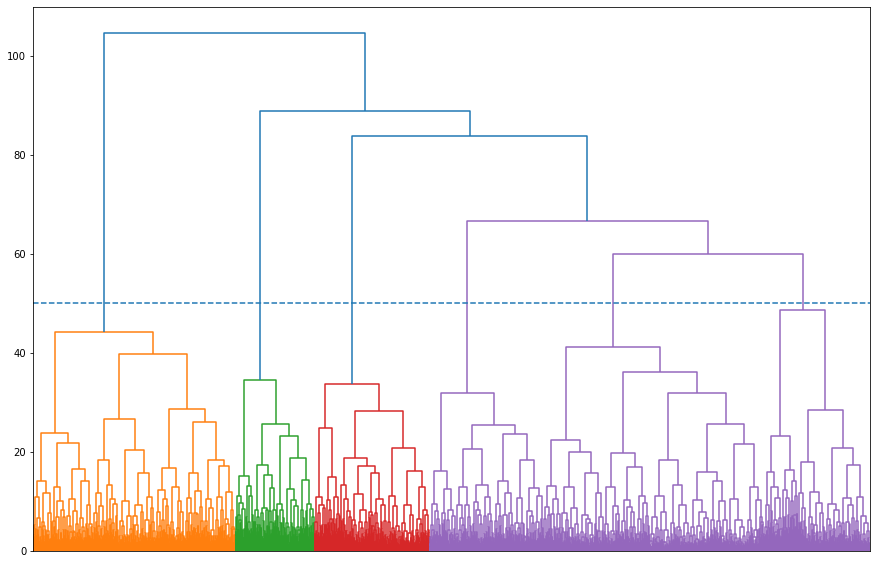

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.axhline(50, ls='--')
plt.xticks([])
plt.show() 

Оптимальная разбивка, предположу, будет на 6 кластеров (правый фиолетовый я бы разбил ещё на 3, по пунктирной линии).

#### <a id='шаг4.4'></a>Обучу модель кластеризации на основании алгоритма K-Means и спрогнозирую кластеры клиентов. Число кластеров приму за 5.

In [26]:
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_st) # применяем алгоритм к данным и формируем вектор кластеров

In [27]:
gym['Cluster_km'] = labels

<a id='шаг4.5'></a>Сравнение средних по кластерам

In [28]:
gym.groupby('Cluster_km').mean().T

Cluster_km,0,1,2,3,4
gender,0.522078,0.480787,0.559567,0.509603,0.495726
Near_Location,0.862338,0.812559,0.858002,0.750320,0.943376
Partner,0.470130,0.000000,0.338147,1.000000,0.752137
Promo_friends,0.306494,0.086223,0.197353,0.451985,0.541667
Phone,0.000000,1.000000,0.998797,1.000000,1.000000
Contract_period,4.787013,1.866917,2.730445,2.554417,11.352564
Group_visits,0.425974,0.325211,0.448857,0.303457,0.564103
Age,29.301299,28.145267,30.196149,28.499360,29.993590
Avg_additional_charges_total,143.957664,131.369042,164.579011,129.812508,164.563799
Month_to_end_contract,4.475325,1.791003,2.519856,2.370038,10.376068


Получили 2 кластера, где отток составляет около половины клиентов.

Определю относительный разброс по параметрам между кластерами:

In [29]:
cluster_means = gym.groupby('Cluster_km').mean()

In [30]:
deviation = (cluster_means.max() - cluster_means.min()) / cluster_means.max()
deviation.sort_values(ascending=False)

Phone                                1.000000
Partner                              1.000000
Churn                                0.957276
Promo_friends                        0.840819
Contract_period                      0.835551
Month_to_end_contract                0.827391
Avg_class_frequency_current_month    0.629574
Avg_class_frequency_total            0.547199
Lifetime                             0.531848
Group_visits                         0.462053
Avg_additional_charges_total         0.211245
Near_Location                        0.204644
gender                               0.140787
Age                                  0.067919
dtype: float64

Как видно, меньше всего различается пол и возраст.

<a id='шаг4.7'></a>Для каждого полученного кластера рассчитаю долю оттока.

In [31]:
gym.groupby('Cluster_km')['Churn'].mean().sort_values()

Cluster_km
4    0.023504
2    0.048135
0    0.267532
3    0.395647
1    0.550141
Name: Churn, dtype: float64

Надежнее всего клиенты из 2 и 4 кластеров, очень низкая вероятность оттока (единицы процентов), в 1 группе уходит четверть, а больше всего - в 3 почти половина и в 0 - половина пользователей.

Сортировка кластеров по вероятности ухода:

In [32]:
def appoint_clusters(x):
    if x == 3:
        return 0
    elif x == 1:
        return 1
    elif x == 4:
        return 2
    elif x == 2:
        return 3
    elif x == 0:
        return 4
    return 'error'

In [33]:
gym['Cluster_sorted'] = gym['Cluster_km'].apply(lambda x: appoint_clusters(x))

In [34]:
# проверка сортировки
gym.groupby(['Cluster_sorted'])['Churn'].mean()

Cluster_sorted
0    0.395647
1    0.550141
2    0.023504
3    0.048135
4    0.267532
Name: Churn, dtype: float64

##### <a id='шаг4.6'></a>Сравнение распределения признаков по кластерам

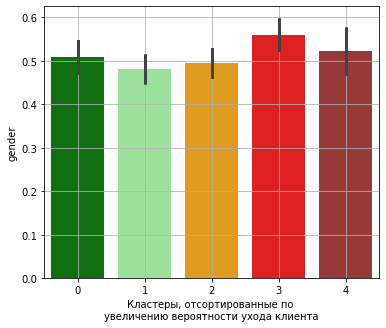

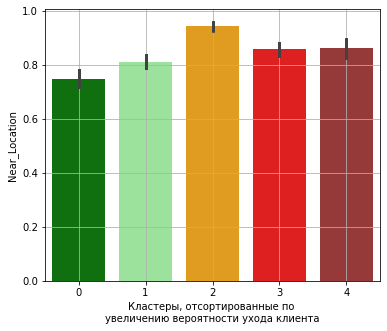

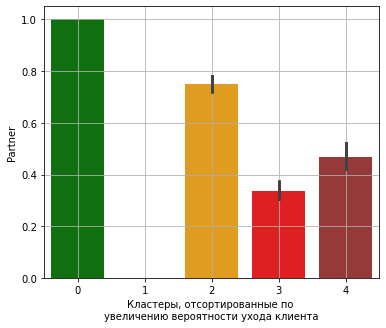

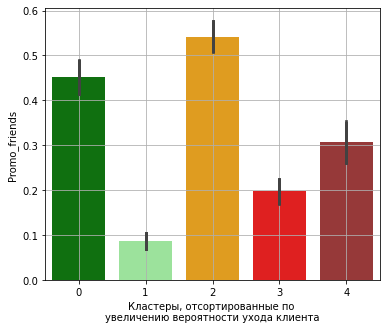

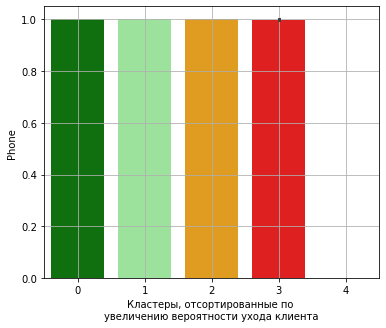

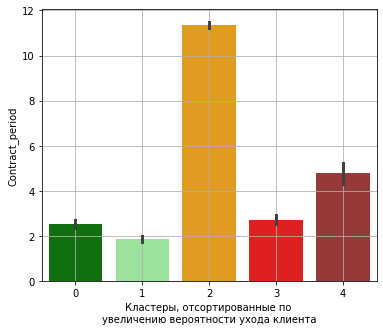

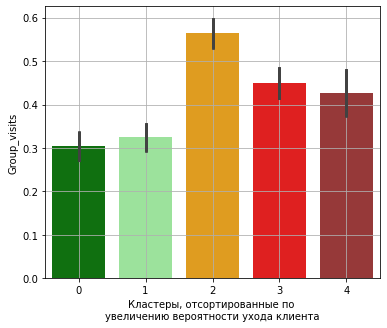

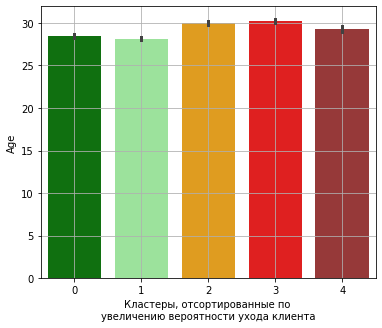

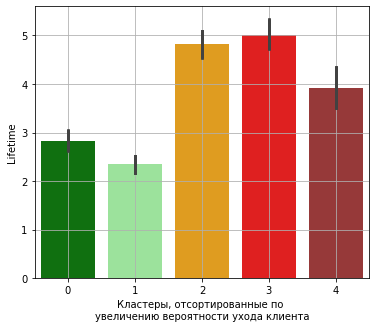

In [35]:
# столбчатые диаграммы
color_dict = dict({0:'green',
                  1:'lightgreen',
                  2: 'orange',
                  3: 'red',
                   4: 'brown'})

for col in X.select_dtypes(include='int64'):
    fig, ax = plt.subplots(figsize=(6,5))
    for i in range(5):
        sns.barplot('Cluster_sorted', col, data=gym, palette=color_dict)
    plt.xlabel('Кластеры, отсортированные по \nувеличению вероятности ухода клиента')
    plt.grid()
    plt.show()

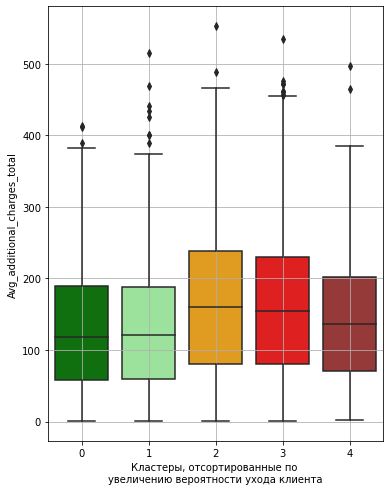

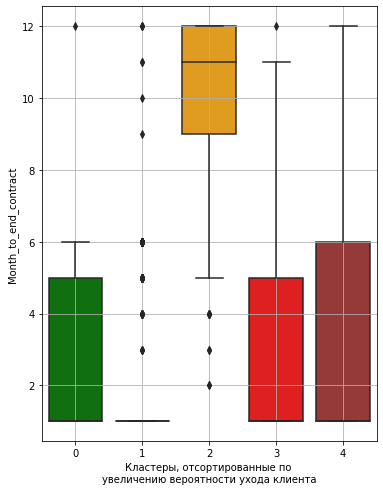

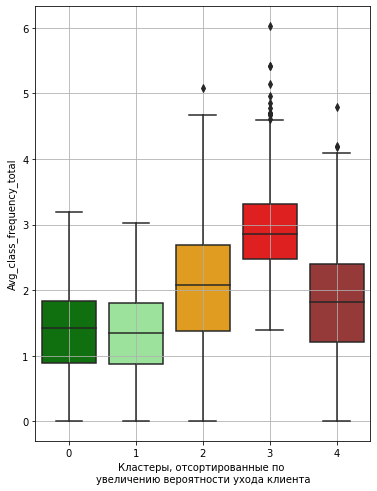

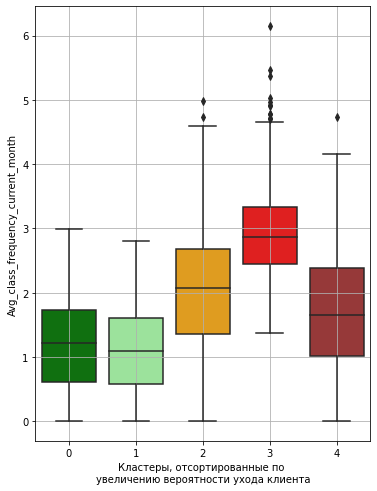

In [36]:
# боксплоты
for col in X.select_dtypes(include='float64'):
    fig, ax = plt.subplots(figsize=(6,8))
    sns.boxplot('Cluster_sorted', col, data=gym, palette=color_dict)
    plt.xlabel('Кластеры, отсортированные по \nувеличению вероятности ухода клиента')
    plt.grid()
    plt.show()

**Выводы**:  
Кластеризация выявила группы клиентов:  
- 0 - наименьшее время занятий (менее 3 месяцев), реже всего посещают занятия (медиана чуть больше 1 раза в неделю)
- 1 - нет телефона
- 2 - чаще всего посещают занятия - почти 3 раза в неделю в среднем
- 3 - спортзал далеко от дома, наименее вероятное наличие скидки от друзей, меньше всего посещают групповые занятия, наименьшее время жизни (меньше 3 месяцев)  
нюанс: тратят чуть меньше денег
- 4 - группа с наибольшим количеством партнерских скидок (почти 0.8 в среднем против других не дотягивающих до 0.5), более вероятное наличие скидок от друзей (почти 0.6 при макс других кластеров 0.3), самый долгий срок текущего абонемента (более 10 месяцев), большое количество времени до окончания его действия  
нюанс: тратят чуть больше денег

Больше всего нас интересуют группы 3 и 4 как наиболее часто прекращающие занятия.
Для группы 3 можно посоветовать:
- Предлагать скидки на групповые занятия
- Предлагать льготное продление абонемента
Группа 4 и так пользуется всеми возможными привилегиями, и т.к. они тратят больше денег, можно попробовать их заинтересовать, предложив (естественно, со скидкой), как более обеспеченным клиентам, индивидуальные занятия с тренером и дополнительное тестирование для отслеживания прогресса.

## Шаг 5. <a id='шаг5'></a>Общие выводы

### Предобработка
Данные для исследования были предоставлены в достаточном количестве - 4000 для 13 параметров и простой классификации. Пропусков и дубликатов в данных не было.

Уходит приблизительно четверть клиентов, 3/4 остаются. Метрика accuracy в данном случае будет менее точна, лучше показывают качество алгоритма precision и recall.

### Предварительный анализ:

Портрет среднестатистического клиента:
- любой пол
- живёт поблизости
- указал телефон для связи
- 27-31 год
- Потратил 80-200 единиц (долларов?) на другие услуги.
- Срок абонемента 1-6 месяцев.
- До конца абонемента 1-6 месяцев.
- Посещает занятия уже 1-5 месяцев с частотой 1-3 раза в неделю.

Менее характерно:
- скорее без скидки от друзей

### Алгоритмы машинного обучения с учителем:
Предварительно была проведена стадартизация признаков, т.к. они сильно отличались по параметрам распределения. Были обучены модели:

- логистической регрессии
- случайного леса

Для логистической регрессии, в силу линейности алгоритма, были отфильтрованы признаки с большой взаимной корреляцией во избежание проблемы мультиколлинеарности. Это `общее время подписки` и `общая частота занятий`.

случайный лес лучше показал себя в плане точности (`precision`), т.е. из всех им предсказанных пользователей, для которых есть риск ухода, реально уйдут около 89%. Если бизнес планирует достаточно серьезно вкладываться в этих клиентов, лучше использовать алгоритм с большим `precision`, т.е. случайный лес.  
Если же важно сохранить как можно больше клиентов, а вложения не так велики или вторичны - логистическая регрессия показала себя лучше, обеспечив 84% выявленных из всех уходящих пользователей.

### Кластеризация выявила группы клиентов:
- 0 - наименьшее время занятий (менее 3 месяцев), реже всего посещают занятия (медиана чуть больше 1 раза в неделю)
- 1 - нет телефона
- 2 - чаще всего посещают занятия - почти 3 раза в неделю в среднем
- 3 - спортзал далеко от дома, наименее вероятное наличие скидки от друзей, меньше всего посещают групповые занятия, наименьшее время жизни (меньше 3 месяцев)  
нюанс: тратят чуть меньше денег
- 4 - группа с наибольшим количеством партнерских скидок (почти 0.8 в среднем против других не дотягивающих до 0.5), более вероятное наличие скидок от друзей (почти 0.6 при макс других кластеров 0.3), самый долгий срок текущего абонемента (более 10 месяцев), большое количество времени до окончания его действия  
нюанс: тратят чуть больше денег

### Рекомендации для бизнеса:
Больше всего нас интересуют группы 3 и 4 как наиболее часто прекращающие занятия.
Для группы 3 можно посоветовать:
- Предлагать скидки на групповые занятия
- Предлагать льготное продление абонемента

Группа 4 и так пользуется всеми возможными привилегиями, и т.к. они тратят больше денег, можно попробовать их заинтересовать, предложив (естественно, со скидкой), как более обеспеченным клиентам, - индивидуальные занятия с тренером
- дополнительное тестирование для отслеживания прогресса
- дать скидки на доп. услуги (массажный салон, кафе и др).